In [1]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
import pandas as pd
import matplotlib as plt
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.multioutput import MultiOutputClassifier
from sklearn.metrics import f1_score, hamming_loss, classification_report
import pandas as pd

In [2]:
df1 = pd.read_csv('datafix.csv')

In [3]:
df1.head()

,Epitope ID,Epitope Type,Epitope Sequence,Organism,Taxon ID,Protein Name,Protein ID,Protein Accession,Start,End,Total Assays,Tcell Assays,Genome ID,Genome Name,Antibiotic,Resistant Phenotype
0,100020,Linear peptide,ESSALAAAQAMASAAAFETA,Mycobacterium tuberculosis,1773,Uncharacterized PPE family protein PPE44,YP_177677.1,P9WHZ3,81.0,100.0,5,4/5,1773.4309,Mycobacterium tuberculosis C00012916,ethambutol,Susceptible
1,100026,Linear peptide,EVVANRALL,Mycobacterium tuberculosis,1773,Uncharacterized PPE family protein PPE44,YP_177677.1,P9WHZ3,109.0,117.0,4,1/4,1773.3412,Mycobacterium tuberculosis 8871-01,isoniazid,Resistant
2,100028,Linear peptide,FALTVPPAEVVANRALLAEL,Mycobacterium tuberculosis,1773,Uncharacterized PPE family protein PPE44,YP_177677.1,P9WHZ3,101.0,120.0,5,4/5,1773.3777,Mycobacterium tuberculosis C00005448,isoniazid,Susceptible
3,100055,Linear peptide,GEMWAQDASAMYGYAAASAV,Mycobacterium tuberculosis,1773,Uncharacterized PPE family protein PPE44,YP_177677.1,P9WHZ3,141.0,160.0,5,4/5,1773.5087,Mycobacterium tuberculosis TRL0017768-S8,moxifloxacin,Susceptible
4,100119,Linear peptide,HQAAAVGQAGASAFARQVGL,Mycobacterium tuberculosis,1773,Uncharacterized PPE family protein PPE44,YP_177677.1,P9WHZ3,181.0,200.0,4,2/4,1773.5109,Mycobacterium tuberculosis TRL0018733-S5,rifampin,Susceptible


# EDA

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns
# Fungsi untuk menghitung dan menampilkan missing value summary
def missing_value_summary(df, df_name):
    missing = df.isnull().sum().sort_values(ascending=False)
    missing_percent = (missing / len(df)) * 100
    summary_df = pd.DataFrame({
        'Kolom': missing.index,
        'Jumlah Missing': missing.values,
        'Persentase Missing (%)': missing_percent.values
    })
    print(f"\nTop 10 Kolom dengan Missing Value Terbanyak di {df_name}")
    print(summary_df.head(10))

    # Visualisasi
    plt.figure(figsize=(12, 6))
    sns.barplot(
        x=summary_df[summary_df["Jumlah Missing"] > 0]["Persentase Missing (%)"],
        y=summary_df[summary_df["Jumlah Missing"] > 0]["Kolom"]
    )
    plt.title(f'Persentase Missing Value di {df_name}')
    plt.xlabel('Persentase Missing (%)')
    plt.ylabel('Kolom')
    plt.tight_layout()
    plt.show()



Top 10 Kolom dengan Missing Value Terbanyak di df1 - BVBRC_epitope
               Kolom  Jumlah Missing  Persentase Missing (%)
0       Tcell Assays            1288                   12.88
1  Protein Accession             480                    4.80
2              Start             107                    1.07
3                End             107                    1.07
4         Protein ID              16                    0.16
5       Protein Name              13                    0.13
6         Epitope ID               0                    0.00
7       Epitope Type               0                    0.00
8   Epitope Sequence               0                    0.00
9           Organism               0                    0.00


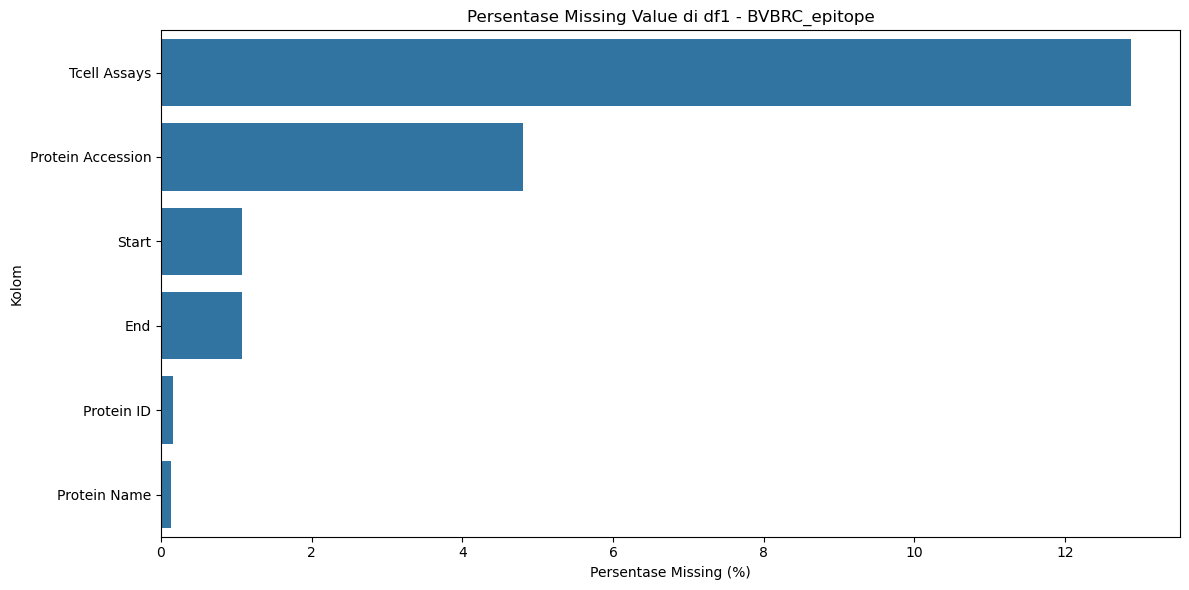

In [6]:
missing_value_summary(df1, 'df1 - BVBRC_epitope')

In [7]:
# Hitung rasio missing value
missing_ratio_df1 = df1.isnull().mean()

# Identifikasi kolom dengan missing value > 50%
drop_cols_df1 = missing_ratio_df1[missing_ratio_df1 > 0.5].index

# Drop kolom langsung dari df1 
df1.drop(columns=drop_cols_df1, inplace=True)

In [8]:
# Ensure df1 has at least 10,000 rows
df1_subset = df1.head(10000).reset_index(drop=True)

# Data Preprocessing

In [10]:
# Example: use df1_subset
df = df1_subset.copy()

# 3️⃣ X = Epitope Sequence → k-mer
def kmer_featurization(sequences, k=6):
    kmers = []
    for seq in sequences:
        seq = str(seq).upper().replace("N", "")
        kmer_list = [seq[i:i+k] for i in range(len(seq) - k + 1)]
        kmers.append(' '.join(kmer_list))
    return kmers


In [11]:
X_seq = df['Epitope Sequence']
X_kmers = kmer_featurization(X_seq, k=6)
vectorizer = CountVectorizer()
X_features = vectorizer.fit_transform(X_kmers)

In [12]:
X_features

<10000x75924 sparse matrix of type '<class 'numpy.int64'>'
	with 94125 stored elements in Compressed Sparse Row format>

In [13]:
# 4️⃣ y = Pivot Antibiotic + Resistant Phenotype
# Convert "Resistant" to 1, "Susceptible" to 0
df['Resistant Binary'] = df['Resistant Phenotype'].map({'Resistant': 1, 'Susceptible': 0})


In [14]:
# Pivot: rows = sample, columns = Antibiotic, values = Resistant Binary
y = df.pivot_table(index=df.index, columns='Antibiotic', values='Resistant Binary', fill_value=0)

print("Shape of X:", X_features.shape)
print("Shape of y:", y.shape)


Shape of X: (10000, 75924)
Shape of y: (10000, 11)


In [15]:
# 5️⃣ Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_features, y, test_size=0.2, random_state=42)

# Modelling

In [17]:
# Model with class_weight
base_model = RandomForestClassifier(n_estimators=100, class_weight='balanced')
multi_model = MultiOutputClassifier(base_model)
multi_model.fit(X_train, y_train)

MultiOutputClassifier(estimator=RandomForestClassifier(class_weight='balanced'))

In [18]:
y_pred = multi_model.predict(X_test)

In [19]:
# Hamming Loss (good for multi-label)
hamming = hamming_loss(y_test, y_pred)
print(f"\nHamming Loss: {hamming:.4f}")


Hamming Loss: 0.0116


In [20]:
from sklearn.metrics import accuracy_score, f1_score, hamming_loss
# Subset accuracy (exact match)
subset_acc = accuracy_score(y_test, y_pred)
print(f"Subset Accuracy (Exact Match Ratio): {subset_acc:.4f}")

Subset Accuracy (Exact Match Ratio): 0.8725


# Decision Tree

In [22]:
from sklearn.tree import DecisionTreeClassifier
# Model: Decision Tree with class_weight
base_model = DecisionTreeClassifier(class_weight='balanced')
multi_model = MultiOutputClassifier(base_model)
multi_model.fit(X_train, y_train)

MultiOutputClassifier(estimator=DecisionTreeClassifier(class_weight='balanced'))

In [23]:
from sklearn.metrics import accuracy_score, hamming_loss, f1_score
# Predict
y_pred = multi_model.predict(X_test)
# Subset accuracy (strict accuracy — all labels correct)
subset_acc = accuracy_score(y_test, y_pred)
print(f"Subset Accuracy (Exact Match): {subset_acc:.4f}")

Subset Accuracy (Exact Match): 0.8505


In [24]:
# Hamming Loss (lower = better)
hamming = hamming_loss(y_test, y_pred)
print(f"Hamming Loss: {hamming:.4f}")

Hamming Loss: 0.0142


# Logistic Regression

In [26]:
from sklearn.linear_model import LogisticRegression

# Model: Logistic Regression with class_weight
base_model = LogisticRegression(class_weight='balanced', max_iter=1000)
multi_model = MultiOutputClassifier(base_model)

# Train
multi_model.fit(X_train, y_train)

MultiOutputClassifier(estimator=LogisticRegression(class_weight='balanced',
                                                   max_iter=1000))

In [27]:
# Predict
y_pred = multi_model.predict(X_test)

In [28]:
# Subset accuracy
subset_acc = accuracy_score(y_test, y_pred)
print(f"Subset Accuracy (Exact Match): {subset_acc:.4f}")

Subset Accuracy (Exact Match): 0.8475


In [29]:
# Hamming Loss
hamming = hamming_loss(y_test, y_pred)
print(f"Hamming Loss: {hamming:.4f}")

Hamming Loss: 0.0147


# Testing

In [31]:
# USER INPUT + MODEL PREDICT

# Ask user to input a sequence
new_sequence = input("Enter Epitope Sequence: ").strip().upper()

# K-mer featurization (use SAME k as training)
new_kmer = kmer_featurization([new_sequence], k=6)

# Vectorize with SAME vectorizer used in training
new_X = vectorizer.transform(new_kmer)

# Predict
predicted_binary = multi_model.predict(new_X)[0]

# Map prediction to antibiotic names
predicted_labels = dict(zip(y.columns, predicted_binary))

# Display result
print("\nPrediction result:")
for antibiotic, label in predicted_labels.items():
    status = 'Resistant' if label == 1 else 'Susceptible'
    print(f"{antibiotic}: {status}")


Enter Epitope Sequence:  ESSALAAAQAMASAAAFETA



Prediction result:
amikacin: Susceptible
amoxicillin: Susceptible
capreomycin: Susceptible
ciprofloxacin: Susceptible
ethambutol: Susceptible
isoniazid: Susceptible
kanamycin: Susceptible
moxifloxacin: Susceptible
pyrazinamide: Susceptible
rifampin: Resistant
streptomycin: Susceptible
